In [69]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import csv
import os
import time

%matplotlib inline 

import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 50)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Retrieval

In [58]:
if not os.path.isdir('./player_data'):
    
    os.makedirs('./player_data', exist_ok=True)

    # Iterate through seasons.
    for i in range (1946, 2020):

        #no data for these years
        if i not in [1946, 1947, 1948, 1949, 1950]:
            continue

        time.sleep(3)

        # Get URL
        url_year_part = str(i) + '-' + str(i + 1)[-2:]
        url = 'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season=' + url_year_part + '&SeasonType=Regular+Season&StatCategory=MIN'

        headers = {
            'referrer': 'https://google.com',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Connection': 'keep-alive',
            'DNT': '1',
            'Host': 'stats.nba.com',
            'Referer': 'https://stats.nba.com/leaders/?Season=1950-51&SeasonType=Regular%20Season&StatCategory=MIN',
            'Sec-Fetch-Dest': 'empty',
            'Sec-Fetch-Mode': 'cors',
            'Sec-Fetch-Site': 'same-origin',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
            'x-nba-stats-origin': 'stats',
            'x-nba-stats-token': 'true',
            'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw=='
            }

        req = requests.get(url, headers=headers)
        print(url)

        stat_dict = json.loads(req.content)
        csv_path = 'player_data/' + url_year_part + '.csv'
        csv_columns = stat_dict['resultSet']['headers']
        with open(csv_path, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(csv_columns)
            for row in stat_dict['resultSet']['rowSet']:
                writer.writerow(row)


## Clustering Runs

In [127]:
InteractiveShell.ast_node_interactivity = "last_expr"

years = [x for x in os.listdir(path='./player_data') if x[-4:] == '.csv']
years.sort()

# initializing K-Means Results list, with header row
results = [['year', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']]

# initializing player statistics
player_stats = [['year', 'player', 'GP', 'MIN', 'PTS', 'REB', 'AST']]

#initializing player clusters
player_clusters = [['year', 'player', 'n_clusters', 'cluster']]

# initializing centroid statistics
centroid_stats = [['year', 'n_clusters', 'cluster', 'PTS', 'REB', 'AST']]

# year by year
#for year in range(1973, 2020):
#for year in range(1951, 2020):
for year in range(2019, 2020):    
    
    print('Working on {}...'.format(year))
    
    df = pd.read_csv('./player_data/' + str(year) + '-' + str(year + 1)[-2:] + '.csv')
    df.insert(0, 'year', year)
    
    cols = ['year', 'PLAYER', 'GP', 'MIN']
    k_means_attributes = ['PTS', 'REB', 'AST']
    cols.extend(k_means_attributes)
    
    # Per 36 stats for K-Means attributes
    # Steals, Blocks start in 1973
    per_36 = df.loc[:,cols]
    for attrib in k_means_attributes:
        per_36.loc[:, attrib] = (per_36[attrib] * (36 / per_36['MIN'])).round(1)
    
    # per_36 dataframe to equalize minutes for K-Means. Also storing as separate file
    player_stats.extend(per_36.to_records(index=False).tolist())
    curr_player_clusters = per_36.loc[:,['year', 'PLAYER']]
        
    # Checking relationships between pts, reb, ast
    #sns.pairplot(per_36[k_means_attributes])
    
    # Scaling
    scaler = preprocessing.StandardScaler()
    per_36_scaled = scaler.fit_transform(per_36[k_means_attributes])
        
    clusters = list(range(1, 11))
#    clusters = [3, 5]
    inertias = []
    silhouettes = []
    avg_dist_from_centroids = []
    
    for k in clusters:
        
        kmeans = cluster.KMeans(n_clusters=k,
                               init='k-means++', #initializes nodes at greater distance from each other
                               random_state=1)
        kmeans.fit(per_36_scaled)
        
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        inertia = kmeans.inertia_
        #silhouette_score = metrics.silhouette_score(per_36_scaled, labels, metric='euclidean')
        
        # Equalizes inertia metric across different numbers of players in league 
        avg_dist_from_centroid = inertia/len(per_36_scaled)
        
        inertias.append(round(inertia, 1))
        #silhouettes.append(round(silhouette_score, 1))
        avg_dist_from_centroids.append(avg_dist_from_centroid)
            
        curr_player_clusters['n_clusters'] = k
        curr_player_clusters['cluster'] = labels
        player_clusters.extend(curr_player_clusters.to_records(index=False).tolist())
        
        # Logs unnormalized PTS/REB/AST values for each centroid, so we have frames of reference 
        # for the clusters each player ends up in
        curr_centroid_stats = pd.DataFrame(data=scaler.inverse_transform(centroids),
                                    columns=k_means_attributes).round(1)
        print(curr_centroid_stats)
        curr_centroid_stats.insert(0, column='year', value=year)
        curr_centroid_stats.insert(1, column='n_clusters', value=k)
        curr_centroid_stats.insert(2, column='label', value=curr_centroid_stats.index)
        print(curr_centroid_stats)
        centroid_stats.extend(curr_centroid_stats.to_records(index=False).tolist()) # maintains data type, no int-->float
        print(centroid_stats)
    #plt.scatter(clusters, inertias)
    #plt.scatter(clusters, silhouettes)
    
    avg_dist_from_centroids.insert(0, year)
    results.append(avg_dist_from_centroids)
        
# results to CSV
csv_path = 'k_means_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for year in results:
        writer.writerow(year)

csv_path = 'player_per_36_stats.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for player_year in player_stats:
        writer.writerow(player_year)
        
csv_path = 'player_clusters.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for player_cluster in player_clusters:
        writer.writerow(player_cluster)
        
csv_path = 'centroid_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for centroid in centroid_stats:
        writer.writerow(centroid)

Working on 2019...
    PTS  REB  AST
0  16.2  6.7  3.5
   year  n_clusters  label   PTS  REB  AST
0  2019           1      0  16.2  6.7  3.5
[['year', 'n_clusters', 'cluster', 'PTS', 'REB', 'AST'], (2019, 1, 0, 16.2, 6.7, 3.5)]
    PTS  REB  AST
0  20.3  5.3  6.2
1  14.6  7.2  2.5
   year  n_clusters  label   PTS  REB  AST
0  2019           2      0  20.3  5.3  6.2
1  2019           2      1  14.6  7.2  2.5
[['year', 'n_clusters', 'cluster', 'PTS', 'REB', 'AST'], (2019, 1, 0, 16.2, 6.7, 3.5), (2019, 2, 0, 20.3, 5.3, 6.2), (2019, 2, 1, 14.6, 7.2, 2.5)]
    PTS   REB  AST
0  14.2   5.4  2.9
1  22.0   5.6  6.7
2  16.4  11.4  2.5
   year  n_clusters  label   PTS   REB  AST
0  2019           3      0  14.2   5.4  2.9
1  2019           3      1  22.0   5.6  6.7
2  2019           3      2  16.4  11.4  2.5
[['year', 'n_clusters', 'cluster', 'PTS', 'REB', 'AST'], (2019, 1, 0, 16.2, 6.7, 3.5), (2019, 2, 0, 20.3, 5.3, 6.2), (2019, 2, 1, 14.6, 7.2, 2.5), (2019, 3, 0, 14.2, 5.4, 2.9), (2019, 3, 1, 

## Points of Interest

In [128]:
results = pd.read_csv('k_means_results.csv')
print(results.head())

centroids = pd.read_csv('centroid_results.csv')
print(centroids.head())

players = pd.read_csv('player_per_36_stats.csv')
print(players.head())

player_clusters = pd.read_csv('player_clusters.csv')
print(player_clusters.tail())

   year  one       two     three      four      five       six     seven  \
0  2019  3.0  2.016259  1.424187  1.148372  0.928159  0.820188  0.742315   

     eight      nine       ten  
0  0.68059  0.622215  0.561995  
   year  n_clusters  cluster   PTS  REB  AST
0  2019           1        0  16.2  6.7  3.5
1  2019           2        0  20.3  5.3  6.2
2  2019           2        1  14.6  7.2  2.5
3  2019           3        0  14.2  5.4  2.9
4  2019           3        1  22.0  5.6  6.7
   year          player  GP   MIN   PTS  REB  AST
0  2019  Damian Lillard  58  36.9  28.2  4.2  7.6
1  2019    James Harden  61  36.7  33.7  6.3  7.3
2  2019      Kyle Lowry  52  36.6  19.4  4.7  7.6
3  2019    Devin Booker  62  36.1  26.0  4.2  6.6
4  2019    Bradley Beal  57  36.0  30.5  4.2  6.1
      year             player  n_clusters  cluster
2625  2019      Nassir Little          10        8
2626  2019  Patrick Patterson          10        0
2627  2019          Raul Neto          10        6
2628  2

### Cluster grouping over time

Hopefully, we'll see our metric get closer to zero year over year for our three-cluster K-means runs, meaning that three clusters (point-wing-big) describes the data better over time.

And hopefully, it will get further from zero for our five-cluster K-means runs, as the point-shooting guard-small forward-power forward-center groupings fall out of fashion.

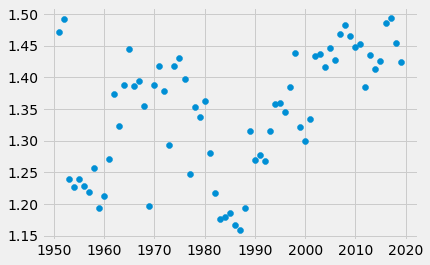

In [36]:
plt.scatter(x=df['year'], y=df['three'])

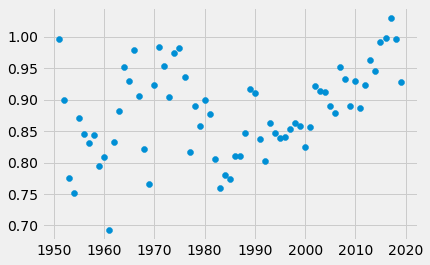

In [37]:
plt.scatter(x=df['year'], y=df['five'])

Nope. Cluster fit was scattered through the 70s, then hit a low point in the mid 80s, and has gradually increased in the time since.

### Exploring year gaps

In [76]:
centroids[(centroids['n_clusters'] == 5) & centroids['year'].isin([1975, 1985, 2005, 2015])].sort_values(['year', 'AST'])

,year,n_clusters,cluster,PTS,REB,AST
1331,1975,5,1,17.241935,8.764516,1.967742
1332,1975,5,2,10.977419,10.564516,2.709677
1333,1975,5,3,15.303030,4.600000,3.121212
1334,1975,5,4,23.537500,9.712500,3.975000
1330,1975,5,0,16.600000,3.893333,5.566667
1882,1985,5,2,9.920833,9.091667,1.604167
1880,1985,5,0,17.448980,9.712245,2.155102
1883,1985,5,3,21.575000,4.947500,3.350000
1884,1985,5,4,13.580000,4.167500,4.967500
1881,1985,5,1,15.619231,3.426923,8.819231


In [83]:
# need two player tables: one for per 36 stats, one for cluster

player_years = centroids.merge(players, how='inner', on=['year', 'n_clusters', 'cluster'], 
                               suffixes=('centroid', 'player'))
player_years.head()

#centroids[(centroids['n_clusters'] == 5) & centroids['year'].isin([2015])].sort_values(['year', 'AST'])

KeyError: 'n_clusters'

### Representative Players for each cluster

In [137]:

temp = centroids.merge(player_clusters, on=['year', 'n_clusters', 'cluster']).merge(players, on=['year', 'player'], suffixes=('_cluster', '_player'))

temp['difference'] = (temp.PTS_cluster - temp.PTS_player).abs() + (temp.REB_cluster - temp.REB_player).abs() + (temp.AST_cluster - temp.AST_player).abs()
temp = temp.sort_values('difference')
#temp.sort_values('year', 'n_clusters', 'AST_cluster', )
print(temp.groupby(['year', 'n_clusters', 'cluster']).head(1).sort_values(['year', 'n_clusters', 'AST_cluster']))

#temp = temp.groupby(['year', 'n_clusters', 'cluster']).apply(lambda x: x.sort_values['difference'])
#print(temp)


      year  n_clusters  cluster  PTS_cluster  REB_cluster  AST_cluster  \
2240  2019           1        0         16.2          6.7          3.5   
1411  2019           2        1         14.6          7.2          2.5   
131   2019           2        0         20.3          5.3          6.2   
2082  2019           3        2         16.4         11.4          2.5   
1552  2019           3        0         14.2          5.4          2.9   
...    ...         ...      ...          ...          ...          ...   
439   2019          10        5         20.5         10.5          3.2   
599   2019          10        6         13.1          5.0          5.2   
529   2019          10        9         24.2          4.8          6.2   
1529  2019          10        2         16.0          4.7          7.8   
339   2019          10        1         29.5          9.1          8.0   

              player  GP   MIN  PTS_player  REB_player  AST_player  difference  
2240   Terence Davis  64  17.0